## Introduction

The aim of this project is to cluster the food outlets in Delhi,India based on:
1. Avg. price
2. Rating
3. Location 
4. Coronavirus cases in the district 
5. Online Delivery Service

This will help people identify food outlets that not only serve good food at a decent price but are also safe to go to.

With the current outbreak of coronavirus and the never-ending lockdowns, people have become very cautious about their safety and hygience. Eventually, once the lockdown ends and people can resume going to different food outlets, they will not only look at food outlets that serve good quality food at a decent price but will also look at the hygiene rating and the area in which the food outlet is located in to ensure that safety and hygiene are not being compromised. 

This will also help food outlets take precautionary measures and improve their hygiene and safety mesaures in case the outlet is located in a district with high number of cases.

## Data

We will be merging data from 3 APIs:

1. <b>Covid19 API</b> - To get all the confirmed coronavirus cases in the different districts of Delhi


2. <b>FourSqaure API</b> - Use the location coordinates of the districts we received from the Covid19 API and pass it as input to the   FourSqaure API to retrieve 100 venues within 4 kms for each district of Delhi.


3. <b>Zomato API</b> - We will pass the venues and location coordinates retrieved from the FourSqaure API as input to the Zomato API to get information about the restaurant like ratings, avg. price, review count, whether it has online delivery,etc.

We will also be using web scraping to extract the hygiene ratings of the restaurants.

<b> Get the district level data for Delhi using Covid19 API </b>

In [6]:
!pip install geopy

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests
import json

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
!pip install folium
import folium

In [8]:
import warnings
warnings. filterwarnings("ignore")

In [9]:
response = requests.get('https://api.covid19india.org/v2/state_district_wise.json')
content = response.content
parsed = json.loads(content)
len(parsed)

37

In [10]:
dfs = []

for i in parsed:
#     print(i['state'])
    state_name = i['state']
    state_code = i['statecode']
    
#     df = pd.DataFrame()

    df = pd.DataFrame(i['districtData'])
    df['state name'] = state_name
    df['state code'] = state_code
    
    dfs.append(df)

In [11]:
district_level = pd.concat(dfs)
district_level.head()

,district,notes,active,confirmed,deceased,recovered,delta,state name,state code
0,Unassigned,,8250,8250,0,0,"{'confirmed': 418, 'deceased': 0, 'recovered': 0}",State Unassigned,UN
0,Nicobars,,0,0,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Andaman and Nicobar Islands,AN
1,North and Middle Andaman,,0,1,0,1,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Andaman and Nicobar Islands,AN
2,South Andaman,,0,32,0,32,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Andaman and Nicobar Islands,AN
0,Foreign Evacuees,,127,131,0,4,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Andhra Pradesh,AP


<b>Now let's extract the cases only for Delhi and drop and "Unassigned" district areas</b>

In [12]:
covid_DL=district_level[(district_level['state code']=='DL') & (district_level['district']!='Unknown')]
covid_DL

,district,notes,active,confirmed,deceased,recovered,delta,state name,state code
0,Central Delhi,,184,184,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
1,East Delhi,,38,38,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
2,New Delhi,,37,37,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
3,North Delhi,,60,60,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
4,North East Delhi,,25,25,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
5,North West Delhi,,31,32,1,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
6,Shahdara,,48,48,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
7,South Delhi,,70,70,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
8,South East Delhi,,130,130,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL
9,South West Delhi,,42,42,0,0,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Delhi,DL


In [13]:
covid_DL.drop(["deceased","delta","notes"],axis=1,inplace=True)
covid_DL.drop(["recovered","active"],axis=1,inplace=True)
covid_DL


,district,confirmed,state name,state code
0,Central Delhi,184,Delhi,DL
1,East Delhi,38,Delhi,DL
2,New Delhi,37,Delhi,DL
3,North Delhi,60,Delhi,DL
4,North East Delhi,25,Delhi,DL
5,North West Delhi,32,Delhi,DL
6,Shahdara,48,Delhi,DL
7,South Delhi,70,Delhi,DL
8,South East Delhi,130,Delhi,DL
9,South West Delhi,42,Delhi,DL


Gelocator.geocode() is not able to recognize North Delhi and North West Delhi so I have manually entered the coordinates for all the districts of Delhi.

In [14]:
lat=[28.6643,28.6280,28.6139,28.7886,28.7184,28.7186,28.6894,28.4817,28.5630,28.5929,28.6663]
long=[77.2167,77.2956,77.2090,77.1412,77.2580,77.0685,77.2919,77.1873,77.2611,77.0346,77.0680]

covid_DL['Latitude']=lat
covid_DL['Longitude']=long

covid_DL

,district,confirmed,state name,state code,Latitude,Longitude
0,Central Delhi,184,Delhi,DL,28.6643,77.2167
1,East Delhi,38,Delhi,DL,28.6280,77.2956
2,New Delhi,37,Delhi,DL,28.6139,77.2090
3,North Delhi,60,Delhi,DL,28.7886,77.1412
4,North East Delhi,25,Delhi,DL,28.7184,77.2580
5,North West Delhi,32,Delhi,DL,28.7186,77.0685
6,Shahdara,48,Delhi,DL,28.6894,77.2919
7,South Delhi,70,Delhi,DL,28.4817,77.1873
8,South East Delhi,130,Delhi,DL,28.5630,77.2611
9,South West Delhi,42,Delhi,DL,28.5929,77.0346


<b> Foursqaure API </b>

In [1]:
CLIENT_ID = 'Client ID' 
CLIENT_SECRET = 'Client Secret key' 
VERSION = '20180604'
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius=4000 #4 km
LIMIT=100

Your credentials:
CLIENT_ID: Client ID
CLIENT_SECRET:Client Secret key


In [16]:
covid_DL['district']

0        Central Delhi
1           East Delhi
2            New Delhi
3          North Delhi
4     North East Delhi
5     North West Delhi
6             Shahdara
7          South Delhi
8     South East Delhi
9     South West Delhi
10          West Delhi
Name: district, dtype: object

We will pass the above district's latitude and longtitude to the FourSqaure API>

In [17]:
def get_cat_type(row):
    categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
foursquare_venues=pd.DataFrame()

dfs = []


In [19]:
for latitude,longitude,dis,cases in zip(covid_DL['Latitude'],covid_DL['Longitude'],covid_DL['district'],covid_DL['confirmed']):
    
    fsq_url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius, 
    LIMIT)
    fsq_request=requests.get(fsq_url).json()
    fsq_venues=json_normalize(fsq_request['response']['groups'][0]['items'])
    column_names=['venue.id','venue.location.lat', 'venue.location.lng','venue.name','venue.categories']
    fsq_ven_df=fsq_venues[column_names]
    fsq_ven_df['venue.categories']=fsq_ven_df.apply(get_cat_type,axis=1)
    fsq_ven_df['district']=dis
    fsq_ven_df['confirmed']=cases
    dfs.append(fsq_ven_df)

In [20]:
foursquare_venues = pd.concat(dfs)
foursquare_venues.head()

,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.categories,district,confirmed
0,4fe1cd59e4b00017d7fcbd78,28.662689,77.226300,Jolly Creations Designer Boutique,Boutique,Central Delhi,184
1,4d9d759348b6224b70c2249f,28.658050,77.223377,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184
2,5662936e498e19a9801a663f,28.657325,77.224138,Amritsari Lassi Wala,Snack Place,Central Delhi,184
3,56d96bfc498e2749a4ae6bf6,28.653247,77.232309,Haveli Dharampura,Hotel,Central Delhi,184
4,518ddbdf498eab246c509547,28.645537,77.217701,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184


In [74]:
foursquare_venues.to_csv(r"C:\Users\aasth\Desktop\Data analytics\IBM Data Science Course\Unit 9 - Applied Capstone Project\Week 4\FourSqaure data.csv")

In [93]:
foursquare_venues['venue.categories'].value_counts()
#There are a lot of venues present that might not be present on Zomato so let's drop those

Indian Restaurant       51
Café                    38
Hotel                   32
Fast Food Restaurant    25
Pizza Place             24
                        ..
Miscellaneous Shop       1
Diner                    1
Light Rail Station       1
Business Service         1
Spiritual Center         1
Name: venue.categories, Length: 115, dtype: int64

In [98]:
foursquare_venues.shape

(465, 7)

Zomato API does not let me pull data for 465 rows so we only be taking those rows from FourSquare API that are a food outlet or a convenience store.

In [105]:
foursquare_venues=foursquare_venues[foursquare_venues['venue.categories'].isin(['Asian Restaurant',
'Bakery',
'Bar',
'BBQ Joint',
'Beer Garden',
'Bengali Restaurant',
'Bistro',
'Breakfast Spot',
'Burger Joint',
'Burrito Place',
'CafÃ©',
'Candy Store',
'Chinese Restaurant',
'Cocktail Bar',
'Coffee Shop',
'Convenience Store',
'Deli / Bodega',
'Department Store',
'Dessert Shop',
'Diner',
'Donut Shop',
'Dumpling Restaurant',
'English Restaurant',
'Fast Food Restaurant',
'Food',
'Food & Drink Shop',
'Food Court',
'Food Truck',
'French Restaurant',
'Fried Chicken Joint',
'Gastropub',
'Grocery Store',
'Hotel',
'Hotel Bar',
'Ice Cream Shop',
'Indian Restaurant',
'Indie Movie Theater',
'Irani Cafe',
'Italian Restaurant',
'Japanese Restaurant',
'Karnataka Restaurant',
'Lounge',
'Mediterranean Restaurant',
'Middle Eastern Restaurant',
'Molecular Gastronomy Restaurant',
'Mughlai Restaurant',
'Multiplex',
'North Indian Restaurant',
'Northeast Indian Restaurant',
'Pizza Place',
'Portuguese Restaurant',
'Pub',
'Resort',
'Restaurant',
'Sandwich Place',
'Shopping Mall',
'Smoke Shop',
'Snack Place',
'South Indian Restaurant',
'Thai Restaurant',
'Tibetan Restaurant']
)]

In [106]:
foursquare_venues.shape

(327, 7)

In [115]:
foursquare_venues['venue.categories'].value_counts()

Indian Restaurant                  51
Hotel                              32
Fast Food Restaurant               25
Pizza Place                        24
Coffee Shop                        19
Chinese Restaurant                 14
Italian Restaurant                 11
Restaurant                         10
Bakery                              9
Lounge                              9
Donut Shop                          8
Dessert Shop                        7
Asian Restaurant                    6
Shopping Mall                       5
Ice Cream Shop                      5
South Indian Restaurant             5
Food Truck                          5
BBQ Joint                           5
Bar                                 4
Food & Drink Shop                   4
Tibetan Restaurant                  4
Snack Place                         4
North Indian Restaurant             4
Deli / Bodega                       3
Mediterranean Restaurant            3
Hotel Bar                           3
Sandwich Pla

I'm only able to query a maximum of 172 restaurants so we will choose the top restaurants that roughly add upto 172.

In [120]:
foursquare_venues=foursquare_venues[foursquare_venues['venue.categories'].isin(['Indian Restaurant','Hotel','Fast Food Restaurant','Pizza Place','Coffee Shop','Chinese Restaurant','Italian Restaurant'])]
#foursquare_venues.to_csv(r"C:\Users\aasth\Desktop\Data analytics\IBM Data Science Course\Unit 9 - Applied Capstone Project\Week 4\FourSqaure data_Cleaned.csv")
foursquare_venues.shape

(176, 7)

In [88]:
#foursquare_venues2=foursquare_venues[172:]
#foursquare_venues2.head()
#for i,j,k in zip(foursquare_venues2['venue.name'],foursquare_venues2['venue.location.lat'],foursquare_venues2['venue.location.lng']):
    #print(i)

,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.categories,district,confirmed
17,4d09df938ea0a14343e1e273,28.603001,77.199182,Nehru Memorial Museum And Library | नेहरू स्मा...,History Museum,New Delhi,37
18,54783eab498e910f8bd1781d,28.634455,77.222139,Naturals Ice Cream,Ice Cream Shop,New Delhi,37
19,528b98b611d285b84d9b26b1,28.601569,77.185923,Amour Bistro,Café,New Delhi,37
20,4cbb1be690c9a14312d692d6,28.604504,77.223592,The House of Ming,Chinese Restaurant,New Delhi,37
21,519ba450498eb0c559152d94,28.632319,77.216445,HOTEL SARAVANA BHAVAN,South Indian Restaurant,New Delhi,37


<b> Zomato API </b>

In [121]:

headers = {
    'user-key': 'zomato key'
}

venues_information = []
for i,j,k in zip(foursquare_venues['venue.name'],foursquare_venues['venue.location.lat'],foursquare_venues['venue.location.lng']):
    
    url=('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(i,j,k)
    response = requests.get(url, headers=headers).json()
    print("Hi")
    if len(response['restaurants'])>0:
        print(i)
        for i in range(len(response['restaurants'])):
            zom_venue=[]
            zom_venue.append(response['restaurants'][i]['restaurant']['name'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['latitude'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['longitude'])
            zom_venue.append(response['restaurants'][i]['restaurant']['average_cost_for_two'])
            zom_venue.append(response['restaurants'][i]['restaurant']['price_range'])
            zom_venue.append(response['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['address'])
            zom_venue.append(response['restaurants'][i]['restaurant']['cuisines'])
            zom_venue.append(response['restaurants'][i]['restaurant']['has_online_delivery'])
            zom_venue.append(response['restaurants'][i]['restaurant']['all_reviews_count'])
            zom_venue.append(response['restaurants'][i]['restaurant']['url'])
            venues_information.append(zom_venue)
           
    else:
        venues_information.append(np.zeros(6))

Hi
Kake Di Hatti | काके दी हट्टी
Hi
Haveli Dharampura
Hi
bloomrooms @ New Delhi Railway Station
Hi
Karim's | करीम | کریم (Karim's)
Hi
Sagar Ratna
Hi
Khan Chacha | खान चाचा | خان چاچا
Hi
Nizam's Kathi Kabab | निजा़म काठी कबाब
Hi
Rico's
Hi
Rajdhani Thali
Hi
Starbucks
Hi
Changezi Chicken
Hi
Panchayat Paan Parlour
Hi
Starbucks | स्टारबक्स
Hi
QD's New
Hi
Maidens Hotel
Hi
moets
Hi
Chicago Pizza
Hi
McDonald's
Hi
Hotel Broadway New Delhi
Hi
Suruchi Restaurant
Hi
Chache Di Hatti | चाचे दी हट्टी
Hi
Domino's Pizza
Hi
Domino's Pizza
Hi
Taj Princess Hotel
Hi
McDonald's
Hi
KFC
Hi
cafe coffee day
Hi
McDonald's
Hi
McDonald's
Hi
Cafe Coffee Day
Hi
Karim's
Hi
Pizza Hut Karol Bagh
Hi
Café Coffee Day
Hi
Cafe' Coffee Day
Hi
Pizza Hut
Hi
Bercos
Hi
The Embassy
Hi
Punjab Sweet Corner
Hi
Momo's Point
Hi
KFC
Hi
Angan
Hi
Tara Palace Daryaganj
Hi
Radisson Blu Hotel
Hi
Pizza Hut
Hi
Cafe Wink
Hi
Fraser Suites
Hi
Bercos
Hi
Domino's Pizza
Hi
Café Coffee Day
Hi
The Leela Ambience Delhi Convention Hotel
Hi
Pizza Hut
Hi

In [122]:
zomato_venues=pd.DataFrame()
zomato_venues = pd.DataFrame(venues_information, 
                                 columns = ['venue', 'latitude', 
                                            'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address','cuisines','online_delivery','review_count','url'])

zomato_venues.to_csv(r"C:\Users\aasth\Desktop\Data analytics\IBM Data Science Course\Unit 9 - Applied Capstone Project\Week 4\Zomato data.csv")

<b> Trying to extract Hygiene ratings for the above restaurants </b>

In [123]:
!pip install requests
!pip install bs4

In [126]:
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url
0,Kake Di Hatti,28.6580019670,77.2233714536,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...
1,Lakhori - Haveli Dharampura,28.6532545820,77.2322656587,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...
2,XO Cafe,28.6457967876,77.2177612782,950.0,2.0,0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...
3,A One Chicken Corner,28.6500555071,77.2163930163,200.0,1.0,0,"BB 338/1, Near Masjid, Main Market Nabi Karim,...",Mughlai,0.0,0.0,https://www.zomato.com/ncr/a-one-chicken-corne...
4,Sagar Ratna,28.6354399691,77.2204984725,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...


In [138]:
import requests
from bs4 import BeautifulSoup

hygiene_rating=[]

for u in zomato_venues['url']:
    if(u!=None):
        url = u
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0'}
        soup = BeautifulSoup(requests.get(url, headers=headers).content, 'html.parser')
        if((soup.select_one('p:contains("HYGIENE RATING") + p'))==None):
            hygiene_rating.append(0)
        else:
            hygiene_rating.append(soup.select_one('p:contains("HYGIENE RATING") + p').get_text(strip=True).split('-')[0])
    else:
        hygiene_rating.append(0)
    

In [151]:
zomato_venues['hygiene']=hygiene_rating
zomato_venues['hygiene'].value_counts()

0     170
5       3
4       3
Name: hygiene, dtype: int64

We can see that most restaurants have "0" hygiene rating which means the hygiene rating is not specified on Zomato. We will not be using this for clustering since only 6 restaurants have hygiene ratings.

## Data Cleaning

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [156]:
del_lat=28.7041
del_long=77.1025

del_map = folium.Map(location = [del_lat, del_long])

for name, latitude, longitude in zip(foursquare_venues['venue.name'], foursquare_venues['venue.location.lat'], foursquare_venues['venue.location.lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(del_map)  

del_map

We will plot Zomato data on map.

In [155]:
del_map = folium.Map(location = [del_lat, del_long])

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(del_map)  

del_map

Visually, most of the locations seem to match however we have to be careful about combining data from 2 different datasets.
To combine the two datasets, I'm going to check if the latitude and longitude values of each corresponding venue from the Zomato API and the FourSquare API match since we used the venue's coordinates as inputs to Zomato API to get more information about the venue. Thus, I'll round both the latitude and longitude values upto 4 decimal places. In order to do that, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0005 which should ideally mean that the two locations are same. This is an assumption we've taken for this project.

In [157]:
foursquare_venues['venue.location.lat'] = foursquare_venues['venue.location.lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['venue.location.lng'] = foursquare_venues['venue.location.lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [161]:
zomato_venues.reset_index(inplace=True)
foursquare_venues.reset_index(inplace=True)

In [164]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset.head()
dataset.columns
dataset['lat_diff'] = dataset['venue.location.lat'] - dataset['latitude']
dataset['lng_diff'] = dataset['venue.location.lng'] - dataset['longitude']

In [177]:
final_venues=dataset[(abs(dataset['lat_diff'])<=0.0005) & (abs(dataset['lng_diff'])<=0.0005)]
final_venues.drop(["index","venue.id","venue.location.lat","venue.location.lng"],axis=1,inplace=True)
final_venues

,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff
0,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184,Kake Di Hatti,28.6580,77.2234,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...,0,0.0000,0.0000
1,Haveli Dharampura,Hotel,Central Delhi,184,Lakhori - Haveli Dharampura,28.6533,77.2323,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...,0,-0.0001,0.0000
2,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184,XO Cafe,28.6458,77.2178,950.0,2.0,0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...,0,-0.0003,-0.0001
4,Sagar Ratna,Indian Restaurant,Central Delhi,184,Sagar Ratna,28.6354,77.2205,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...,0,0.0001,0.0001
5,Khan Chacha | खान चाचा | خان چاچا,Indian Restaurant,Central Delhi,184,Khan Chacha,28.6342,77.2210,650.0,2.0,4.1,"D-3, Connaught Place, New Delhi","Rolls, Kebab, Mughlai, North Indian",1.0,938.0,https://www.zomato.com/ncr/khan-chacha-connaug...,0,0.0000,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Golden Dragon,Chinese Restaurant,South West Delhi,42,The Golden Dragon,28.5980,77.0484,1500.0,3.0,3.8,"304, Krishna Plaza-1, Sector 4 Market, Sector ...","Chinese, Seafood",1.0,192.0,https://www.zomato.com/ncr/the-golden-dragon-s...,0,0.0000,0.0000
161,Sagar Ratna South Indian Restaurant,Indian Restaurant,South West Delhi,42,Sagar Ratna,28.5903,77.0602,750.0,2.0,3.3,"3rd Floor, 14, Odeon Plaza, Building 2, Sector...","South Indian, North Indian, Chinese",1.0,381.0,https://www.zomato.com/ncr/sagar-ratna-sector-...,0,-0.0002,-0.0003
164,KFC Sector 4,Fast Food Restaurant,South West Delhi,42,AL Kuresh,28.5978,77.0508,600.0,2.0,3.6,"Shop G-5, Plot 1, Vikas Surya Palaza, Sector 4...","North Indian, Chinese",1.0,6.0,https://www.zomato.com/ncr/al-kuresh-sector-4-...,0,-0.0001,-0.0001
165,KFC,Fast Food Restaurant,South West Delhi,42,KFC,28.5745,77.0673,450.0,1.0,4.0,"Near Sector 9 Metro Station, Sector 9, Dwarka,...","Burger, Fast Food, Finger Food, Beverages",1.0,300.0,https://www.zomato.com/ncr/kfc-sector-9-dwarka...,0,-0.0001,0.0000


We can see that the names for some venues do not match at all. For example, at index 164, the venue name says KFC but Zomato gave us "Al Kuresh". We need to remove these from our table.

In [185]:
final_venues=final_venues[~((final_venues['venue.name']=='Panchayat Paan Parlour') & (final_venues['district']!='New Delhi'))]

In [188]:
final_venues=final_venues[~final_venues['venue.name'].isin(['Changezi Chicken'])]

In [190]:
final_venues=final_venues[~final_venues['venue.name'].isin(["QD's New"])]

In [192]:
final_venues=final_venues[~((final_venues['venue.name']=="Domino's Pizza") & (final_venues['district']!="La Pino'z Pizza"))]

In [193]:
vn=['Cafe Wink',
'The Leela Ambience Delhi Convention Hotel',
'cafe coffee day',
'Perch, Wine And Coffee Bar',
'Khan Chacha',
'Rigo Coffee House ',
'Gopalji Ke Chhole Bhature, Rohini',
"Domino's Pizza",
'haldiram dilshad garden',
'Nashta Paani',
'Indian Accent',
'Royal China',
'Flavours Defence Colony',
'Moolchand Parathe Wala',
'ITC Welcomhotel Dwarka',
'KFC Sector 4',
'Pizza Hut'
]

zm=['Homely Brunch Cafe',
'G2 Cafe',
'Bookss & Beanss Cafe',
'The Blue Door Cafe',
'M:Eat By Blanco',
'Lhasa Thali House',
'Harish Pan Corner',
'Pizza Hut',
'Burger King',
'Le Chaat Factory',
'Veranda - The Manor Hotel',
"L'Opéra Salon de Thé",
'Dolce Gelato',
'Cafe Coffee Day',
'Cafe Coffee Day',
'AL Kuresh',
"Domino's Pizza"
]


for vn,zm in zip(vn,zm):
    final_venues=final_venues[~((final_venues['venue.name']==vn) & (final_venues['venue']==zm))]



In [194]:
final_venues

,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff
0,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184,Kake Di Hatti,28.6580,77.2234,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...,0,0.0000,0.0000
1,Haveli Dharampura,Hotel,Central Delhi,184,Lakhori - Haveli Dharampura,28.6533,77.2323,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...,0,-0.0001,0.0000
2,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184,XO Cafe,28.6458,77.2178,950.0,2.0,0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...,0,-0.0003,-0.0001
4,Sagar Ratna,Indian Restaurant,Central Delhi,184,Sagar Ratna,28.6354,77.2205,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...,0,0.0001,0.0001
5,Khan Chacha | खान चाचा | خان چاچا,Indian Restaurant,Central Delhi,184,Khan Chacha,28.6342,77.2210,650.0,2.0,4.1,"D-3, Connaught Place, New Delhi","Rolls, Kebab, Mughlai, North Indian",1.0,938.0,https://www.zomato.com/ncr/khan-chacha-connaug...,0,0.0000,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Aggarwal Sweets,Indian Restaurant,South West Delhi,42,Aggarwal Restaurant,28.5940,77.0472,400.0,1.0,2.8,"15, Aashirwad Chowk, Sector 12, Dwarka, New Delhi","Street Food, Mithai",0.0,126.0,https://www.zomato.com/ncr/aggarwal-restaurant...,0,-0.0002,0.0003
155,Golden Dragon,Chinese Restaurant,South West Delhi,42,The Golden Dragon,28.5980,77.0484,1500.0,3.0,3.8,"304, Krishna Plaza-1, Sector 4 Market, Sector ...","Chinese, Seafood",1.0,192.0,https://www.zomato.com/ncr/the-golden-dragon-s...,0,0.0000,0.0000
161,Sagar Ratna South Indian Restaurant,Indian Restaurant,South West Delhi,42,Sagar Ratna,28.5903,77.0602,750.0,2.0,3.3,"3rd Floor, 14, Odeon Plaza, Building 2, Sector...","South Indian, North Indian, Chinese",1.0,381.0,https://www.zomato.com/ncr/sagar-ratna-sector-...,0,-0.0002,-0.0003
165,KFC,Fast Food Restaurant,South West Delhi,42,KFC,28.5745,77.0673,450.0,1.0,4.0,"Near Sector 9 Metro Station, Sector 9, Dwarka,...","Burger, Fast Food, Finger Food, Beverages",1.0,300.0,https://www.zomato.com/ncr/kfc-sector-9-dwarka...,0,-0.0001,0.0000


In [198]:
final_venues[final_venues.duplicated()] #No duplicates found

,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff


Let's change the price_for_two column to avg. price for 1.

In [199]:
final_venues['avg_price']=final_venues['price_for_two']/2
final_venues.head()

,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
0,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184,Kake Di Hatti,28.6580,77.2234,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...,0,0.0000,0.0000,250.0
1,Haveli Dharampura,Hotel,Central Delhi,184,Lakhori - Haveli Dharampura,28.6533,77.2323,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...,0,-0.0001,0.0000,1250.0
2,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184,XO Cafe,28.6458,77.2178,950.0,2.0,0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...,0,-0.0003,-0.0001,475.0
4,Sagar Ratna,Indian Restaurant,Central Delhi,184,Sagar Ratna,28.6354,77.2205,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...,0,0.0001,0.0001,375.0
5,Khan Chacha | खान चाचा | خان چاچا,Indian Restaurant,Central Delhi,184,Khan Chacha,28.6342,77.2210,650.0,2.0,4.1,"D-3, Connaught Place, New Delhi","Rolls, Kebab, Mughlai, North Indian",1.0,938.0,https://www.zomato.com/ncr/khan-chacha-connaug...,0,0.0000,-0.0002,325.0


In [200]:
final_venues.shape

(67, 19)

We are left with 67 rows and we're now ready to work with our data. Now let's get to the Methodology.

## Methodology

We will be performing EDA and Clustering of the food outlets based on ratings, avg. price, location, hygiene rating and number of coronavirus cases.

### Exploratory Data Analysis

In [201]:
import seaborn as sns

#### Ratings

Text(0.5, 1.0, 'Distribution of rating of restaurants')

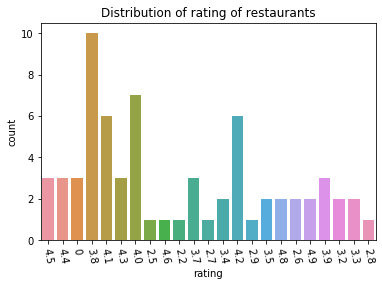

In [214]:
ax=sns.countplot(final_venues['rating'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)
ax.set_title("Distribution of rating of restaurants")

Most restaurants have a rating of 3.8 and 4. 

#### Price

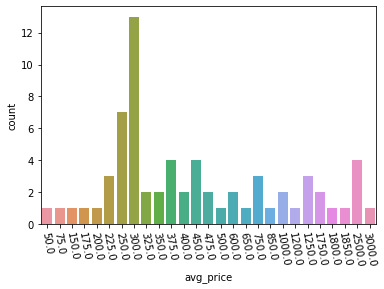

In [204]:
ax=sns.countplot(final_venues['avg_price'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

Most of the restaurants have an average price of 250-300 rupees.

#### Hygiene Rating

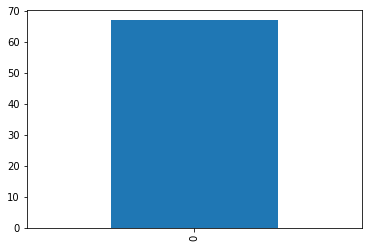

In [213]:
final_venues['hygiene'].value_counts().plot(kind='bar')
plt.show()

All of the resturants have a hygiene rating of 0 which means these restaurants were not rated. Zomato should work on ensuring that hygiene ratings are present for all restaurants especially with this pandemic in place.

<b> Online Delivery </b>

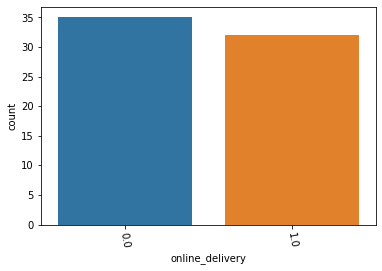

In [215]:
ax=sns.countplot(final_venues['online_delivery'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

Online delivery feature is almost equally distributed. Half of them do not have online delivery while the other half do. Again, restaurants need to emphasize more on online delivery during this pandemic.

<b> Price Range </b>

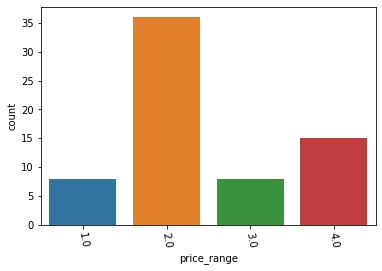

In [216]:
ax=sns.countplot(final_venues['price_range'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

Zomato's "price_range" ranges from 1 to 4(1 being the pocket friendly to 4 being expensive). Most of the restaurants fall more towards pocket friendly. 

<b> District </b>

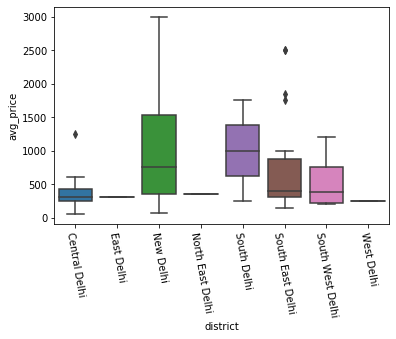

In [221]:
ax=sns.boxplot(final_venues['district'],final_venues['avg_price'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

The high end restaurants fall in New Delhi and South Delhi districts.

In [236]:
final_venues['rating']=final_venues['rating'].apply(lambda x: float(x))

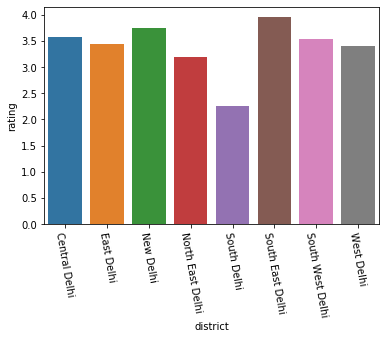

In [243]:
ax=sns.barplot(final_venues['district'],final_venues['rating'],ci=None)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

Let's do a groupby() to understand the above chart better.

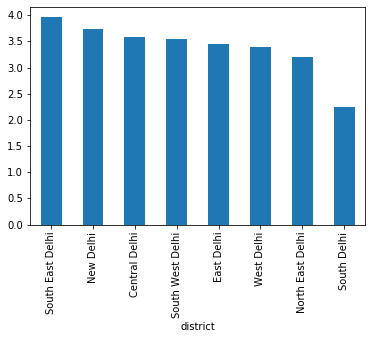

In [244]:
final_venues.groupby(['district']).mean()['rating'].sort_values(ascending=False).plot(kind='bar')

South East Delhi and New Delhi are districts where restaurants have a higher avg. rating.

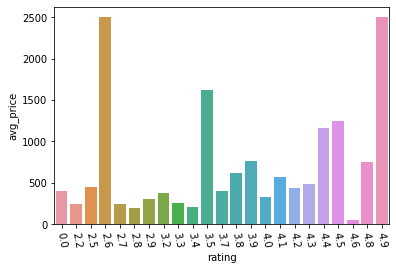

In [245]:
ax=sns.barplot(final_venues['rating'],final_venues['avg_price'],ci=None)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

Restaurants with a rating of 2.6 have an average price of 2500 which is really high! These restaurants need to reconsider their price range given that their rating is not that good.

In [250]:
final_venues[final_venues['rating']==2.6]

,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
81,The Lodhi Hotel,Hotel,New Delhi,37,The Electric Room - The Lodhi,28.5915,77.2381,5000.0,4.0,2.6,"The Lodhi, Lodhi Road, New Delhi","Continental, Finger Food",0.0,44.0,https://www.zomato.com/ncr/the-electric-room-t...,0,0.0002,0.0,2500.0
123,The Lodhi Hotel,Hotel,South East Delhi,130,The Electric Room - The Lodhi,28.5915,77.2381,5000.0,4.0,2.6,"The Lodhi, Lodhi Road, New Delhi","Continental, Finger Food",0.0,44.0,https://www.zomato.com/ncr/the-electric-room-t...,0,0.0002,0.0,2500.0


So the Electric Room which is located in New Delhi and South East Delhi should probably reconsider their price points.

In [382]:
distr_cuisine=pd.DataFrame(final_venues.groupby(['district','cuisines']).count()['venue'].sort_values())
distr_cuisine.reset_index(inplace=True)
distr_cuisine.rename(columns={'venue':'count'},inplace=True)

df=distr_cuisine.merge(covid_DL,left_on='district',right_on='district')
df.head()

,district,cuisines,count,confirmed,state name,state code,Latitude,Longitude
0,Central Delhi,"Burger, Fast Food, Finger Food, Beverages",1,184,Delhi,DL,28.6643,77.2167
1,Central Delhi,"Cafe, Chinese, North Indian, Fast Food",1,184,Delhi,DL,28.6643,77.2167
2,Central Delhi,Chinese,1,184,Delhi,DL,28.6643,77.2167
3,Central Delhi,"Chinese, Thai, Asian",1,184,Delhi,DL,28.6643,77.2167
4,Central Delhi,"Gujarati, Rajasthani, North Indian, Street Food",1,184,Delhi,DL,28.6643,77.2167


In [383]:
del_map = folium.Map(location = [del_lat, del_long])

color_map = {'South East Delhi': 'crimson', 'Central Delhi': 'orange', 'New Delhi': 'pink','South West Delhi':'darkgreen','East Delhi':'blue','South Delhi':'darkblue','North East Delhi':'darkred','West Delhi':'purple'}

for district,cuisine,count, latitude, longitude in zip(df['district'], df['cuisines'], df['count'], df['Latitude'],df['Longitude']):
    label = '{}, {}'.format(district, cuisine)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[district],
        fill=True,
        fill_color=color_map[district],
        fill_opacity = 0.3,
        parse_html = False).add_to(del_map)  

del_map

### Clustering

We will now cluster all these venues based on their price, location and more to identify similar venues and the relationship amongst them.

In [346]:
final_venues.head()

,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
0,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184,Kake Di Hatti,28.6580,77.2234,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...,0,0.0000,0.0000,250.0
1,Haveli Dharampura,Hotel,Central Delhi,184,Lakhori - Haveli Dharampura,28.6533,77.2323,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...,0,-0.0001,0.0000,1250.0
2,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184,XO Cafe,28.6458,77.2178,950.0,2.0,0.0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...,0,-0.0003,-0.0001,475.0
4,Sagar Ratna,Indian Restaurant,Central Delhi,184,Sagar Ratna,28.6354,77.2205,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...,0,0.0001,0.0001,375.0
5,Khan Chacha | खान चाचा | خان چاچا,Indian Restaurant,Central Delhi,184,Khan Chacha,28.6342,77.2210,650.0,2.0,4.1,"D-3, Connaught Place, New Delhi","Rolls, Kebab, Mughlai, North Indian",1.0,938.0,https://www.zomato.com/ncr/khan-chacha-connaug...,0,0.0000,-0.0002,325.0


Let's select the features relevant for clustering.

In [350]:
df_clustering=final_venues[["confirmed","latitude","longitude","rating","online_delivery","review_count","avg_price"]]

We will first use the "Elbow Method" to identify the optimal number of clusters.

<b> Elbow Method </b>

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre. As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.

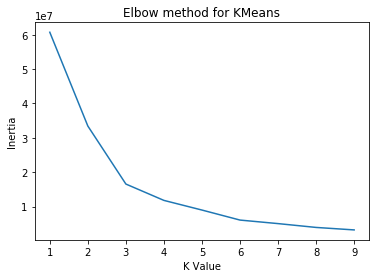

In [354]:
sum_squared_distance=[]

for k in range(1,10):
    kmeans=KMeans(n_clusters=k).fit(df_clustering)
    kmeans.predict(df_clustering)
    sum_squared_distance.append(kmeans.inertia_)

#Let's plot the graph now to find the optimal 'k'

plt.plot(range(1,10),sum_squared_distance)
plt.title("Elbow method for KMeans")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.show()

<b> Clustering using optimal 'k' </b>

In [357]:
kmeans=KMeans(n_clusters=3).fit(df_clustering)
kmeans.predict(df_clustering)
final_venues.insert(0,'cluster_label',kmeans.labels_)
final_venues.head()

,cluster_label,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
0,0,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184,Kake Di Hatti,28.6580,77.2234,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...,0,0.0000,0.0000,250.0
1,1,Haveli Dharampura,Hotel,Central Delhi,184,Lakhori - Haveli Dharampura,28.6533,77.2323,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...,0,-0.0001,0.0000,1250.0
2,1,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184,XO Cafe,28.6458,77.2178,950.0,2.0,0.0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...,0,-0.0003,-0.0001,475.0
4,1,Sagar Ratna,Indian Restaurant,Central Delhi,184,Sagar Ratna,28.6354,77.2205,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...,0,0.0001,0.0001,375.0
5,1,Khan Chacha | खान चाचा | خان چاچا,Indian Restaurant,Central Delhi,184,Khan Chacha,28.6342,77.2210,650.0,2.0,4.1,"D-3, Connaught Place, New Delhi","Rolls, Kebab, Mughlai, North Indian",1.0,938.0,https://www.zomato.com/ncr/khan-chacha-connaug...,0,0.0000,-0.0002,325.0


<b> Plot clusters on Delhi Map </b>

In [364]:
del_map = folium.Map(location=[del_lat,del_long],zoom_start=10)
color_map = { 0: 'green', 1: 'red', 2: 'blue'}

for venue, cluster, latitude, longitude in zip(final_venues['venue'], final_venues['cluster_label'], 
                                               final_venues['latitude'], 
                                                final_venues['longitude']):
    label = folium.Popup(str(venue) + ', Cluster:' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(del_map)
del_map

Most of the restaurants fall in Cluster 1. Let's look at our 3 clusters in detail.

### Cluster 0

In [385]:
cluster1=final_venues[final_venues['cluster_label']==0]
print("Cluster 0 has: mean price of {:.02f} rupees, avg. rating of {:.02f}, avg. coronoavirus cases of {:.02f}, avg. review count of {:.02f} and spread of online delivery of {:.02f}".format(
cluster1['avg_price'].astype(float).mean(),
cluster1['rating'].astype(float).mean(),
cluster1['confirmed'].astype(float).mean(),
cluster1['review_count'].astype(float).mean(),
cluster1['online_delivery'].astype(float).mean()
))
cluster1.head()

Cluster 0 has: mean price of 631.82 rupees, avg. rating of 4.34, avg. coronoavirus cases of 98.91, avg. review count of 1736.36 and spread of online delivery of 0.36


,cluster_label,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
0,0,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,184,Kake Di Hatti,28.6580,77.2234,500.0,2.0,4.5,"654 666, Fatehpuri, Church Mission Road, Chand...","North Indian, Beverages",0.0,1424.0,https://www.zomato.com/ncr/kake-di-hatti-chand...,0,0.0000,0.0000,250.0
6,0,Nizam's Kathi Kabab | निजा़म काठी कबाब,Indian Restaurant,Central Delhi,184,Nizam's Kathi Kabab,28.6350,77.2195,900.0,2.0,4.1,"H-5/6, Plaza Building, Connaught Place, New Delhi","North Indian, Rolls, Mughlai, Kebab, Beverages",0.0,1299.0,https://www.zomato.com/ncr/nizams-kathi-kabab-...,0,-0.0001,0.0000,450.0
9,0,Starbucks,Coffee Shop,Central Delhi,184,Starbucks Coffee,28.6320,77.2177,600.0,2.0,4.3,"Block A, Hamilton House, Connaught Place, New ...","Cafe, Desserts",0.0,1713.0,https://www.zomato.com/ncr/starbucks-coffee-1-...,0,0.0000,0.0000,300.0
35,0,Bercos,Chinese Restaurant,Central Delhi,184,Berco's,28.6805,77.2081,700.0,2.0,4.0,"38/UA, Bungalow Road, Kamla Nagar, New Delhi","Chinese, Thai, Asian",1.0,1491.0,https://www.zomato.com/ncr/bercos-kamla-nagar-...,0,0.0003,-0.0001,350.0
67,0,The Big Chill Cafe,Italian Restaurant,New Delhi,37,The Big Chill,28.6007,77.2278,1500.0,3.0,4.8,"68-A, Khan Market, New Delhi",Cafe,0.0,2792.0,https://www.zomato.com/ncr/the-big-chill-khan-...,0,0.0000,-0.0002,750.0


### Cluster 1

In [375]:
cluster2=final_venues[final_venues['cluster_label']==1]
print("Cluster 1 has: mean price of {:.02f} rupees, avg. rating of {:.02f}, avg. coronoavirus cases of {:.02f}, avg. review count of {:.02f} and spread of online delivery of {:.02f}".format(
cluster2['avg_price'].astype(float).mean(),
cluster2['rating'].astype(float).mean(),
cluster2['confirmed'].astype(float).mean(),
cluster2['review_count'].astype(float).mean(),
cluster2['online_delivery'].astype(float).mean()
))
cluster2.head()

Cluster 1 has: mean price of 400.53 rupees, avg. rating of 3.50, avg. coronoavirus cases of 119.23, avg. review count of 292.68 and spread of online delivery of 0.60


,cluster_label,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
1,1,Haveli Dharampura,Hotel,Central Delhi,184,Lakhori - Haveli Dharampura,28.6533,77.2323,2500.0,4.0,4.4,"Haveli Dharampura, 2293, Gali Guliyan, Near Ja...","Mughlai, Street Food, Kebab",0.0,381.0,https://www.zomato.com/ncr/lakhori-haveli-dhar...,0,-0.0001,0.0000,1250.0
2,1,bloomrooms @ New Delhi Railway Station,Hotel,Central Delhi,184,XO Cafe,28.6458,77.2178,950.0,2.0,0.0,"Bloom Rooms Hotel, Opposite Ram Nagar Colony, ...","Cafe, Chinese, North Indian, Fast Food",0.0,0.0,https://www.zomato.com/ncr/xo-cafe-paharganj-n...,0,-0.0003,-0.0001,475.0
4,1,Sagar Ratna,Indian Restaurant,Central Delhi,184,Sagar Ratna,28.6354,77.2205,750.0,2.0,3.8,"K-15, Connaught Place, New Delhi","South Indian, North Indian, Chinese",1.0,497.0,https://www.zomato.com/ncr/sagar-ratna-connaug...,0,0.0001,0.0001,375.0
5,1,Khan Chacha | खान चाचा | خان چاچا,Indian Restaurant,Central Delhi,184,Khan Chacha,28.6342,77.2210,650.0,2.0,4.1,"D-3, Connaught Place, New Delhi","Rolls, Kebab, Mughlai, North Indian",1.0,938.0,https://www.zomato.com/ncr/khan-chacha-connaug...,0,0.0000,-0.0002,325.0
12,1,Starbucks | स्टारबक्स,Coffee Shop,Central Delhi,184,Starbucks,28.6808,77.2042,600.0,2.0,4.0,"1st Floor, Zing Food Court, Spark Mall, Kamla ...","Cafe, Desserts",0.0,161.0,https://www.zomato.com/ncr/starbucks-kamla-nag...,0,0.0000,-0.0003,300.0


### Cluster 2

In [387]:
cluster3=final_venues[final_venues['cluster_label']==2]
print("Cluster 2 has: mean price of {:.02f} rupees, avg. rating of {:.02f}, avg. coronoavirus cases of {:.02f}, avg. review count of {:.02f} and spread of online delivery of {:.02f}".format(
cluster3['avg_price'].astype(float).mean(),
cluster3['rating'].astype(float).mean(),
cluster3['confirmed'].astype(float).mean(),
cluster3['review_count'].astype(float).mean(),
cluster3['online_delivery'].astype(float).mean()
))
cluster3.head()

Cluster 2 has: mean price of 2238.89 rupees, avg. rating of 3.91, avg. coronoavirus cases of 82.00, avg. review count of 560.44 and spread of online delivery of 0.00


,cluster_label,venue.name,venue.categories,district,confirmed,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url,hygiene,lat_diff,lng_diff,avg_price
64,2,The Imperial,Hotel,New Delhi,37,Nostalgia at 1911 Brasserie - The Imperial,28.6250,77.2191,6000.0,4.0,3.5,"The Imperial, Janpath, New Delhi","European, Continental",0.0,8.0,https://www.zomato.com/ncr/nostalgia-at-1911-b...,0,0.0005,-0.0004,3000.0
66,2,The Claridges,Hotel,New Delhi,37,Pickwicks - The Claridges,28.6006,77.2170,3600.0,4.0,3.8,"The Claridges, 12, Dr. A.P.J. Abdul Kalam Road...","European, Continental",0.0,125.0,https://www.zomato.com/ncr/pickwicks-the-clari...,0,0.0001,-0.0004,1800.0
81,2,The Lodhi Hotel,Hotel,New Delhi,37,The Electric Room - The Lodhi,28.5915,77.2381,5000.0,4.0,2.6,"The Lodhi, Lodhi Road, New Delhi","Continental, Finger Food",0.0,44.0,https://www.zomato.com/ncr/the-electric-room-t...,0,0.0002,0.0000,2500.0
82,2,Indian Accent,Indian Restaurant,New Delhi,37,Indian Accent,28.5921,77.2377,5000.0,4.0,4.9,"The Lodhi, Lodhi Road, New Delhi",Modern Indian,0.0,1565.0,https://www.zomato.com/ncr/indian-accent-lodhi...,0,-0.0001,0.0003,2500.0
102,2,Tonino,Italian Restaurant,South Delhi,70,Tonino,28.5038,77.1708,3500.0,4.0,4.5,"76/27, Near Metro Pillar 38, MG Road, New Delhi","Italian, Salad",0.0,691.0,https://www.zomato.com/ncr/tonino-mg-road-new-...,0,0.0000,0.0000,1750.0


## Results and Discussion

After collecting data from the Covoid19,Foursquare, Zomato APIs, we got a list of 456+ different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 67 rows and 19 columns.

We noticed that most of the restaurants have an average rating of <b>3.8</b> and 4. We also noticed that the avg. price of most restaurants is 250-300 rupees which is not that expensive.

Zomato's "price_range" feature was also able to give us valuable insights. This feature ranges from 1 to 4(1 being the pocket friendly to 4 being expensive) and turns out that most of the restaurants fall more towards <b>pocket friendly</b>. 

An interesting and concerning observation was made regarding the "hygiene rating" of the restaurants. All of the resturants had a hygiene rating of 0 which means these restaurants were not rated in terms of hygiene. <b>Zomato should work on ensuring that hygiene ratings are present for all restaurants</b> especially with this pandemic in place as it would help consumers enusre their safety and hygiene is not being compromised.

Another interesting observation was that the online delivery feature is almost equally distributed amongst restuarants i.e. Half of them do not have online delivery while the other half do. Again, <b>restaurants need to emphasize more on online delivery</b> during this pandemic.

We also analyzed the dataset at a district level and found that:

1. The "high end" (i.e expensive) restaurants fall in New Delhi and South Delhi districts.


2. South East Delhi and New Delhi are districts where restaurants have a higher avg. rating.


3. Restaurants with a rating of 3.5 have an avg. price of rupees 1500 and restaurants with a rating of 4.9 have and avg.price of 2500 rupees.


4. However, <b>restaurants with a rating of 2.6 also have an average price of 2500</b> which is really high! Upon further analysis, it was found that this was due to "Electric Room in Lodhi Hotel." This outlets is located in New Delhi and South East Delhi. Given that their is so low, they should probably reconsider their price points.


5. In <b>North East Delhi</b>, most of the restaurants serve "North Indian, Fast Food, Mughlai" cuisine.


6. In <b>Central Delhi</b>, most of the restaurants serve "Cafe and Desserts" cuisine.


7. In <b>East Delhi</b>, most of the restaurants serve "South Indian, North Indian and Chinese" cuisine.


8. In <b>New Delhi</b> , most of the restaurants serve "European and Continental" cuisine.


9. In <b>South East Delhi</b>, most of the restaurants serve "North Indian, Mughlai" cuisine.


10. In <b>South Delhi</b>, most of the restaurants serve "Italian,Salad" cuisine.


11. In <b>South West Delhi</b>, most of the restaurants serve "Street food,Mithai" cuisine.


12. In <b>West Delhi</b>, most of the restaurants serve "Cafe,Fast Food, Dessert, Beverages, Sandwich" cuisine.


Now coming to the clustering of the restaurants, we noticed that <b>Cluster 0</b> has a decent price, highest rating, highest review counts and a few coronavirus cases so ideally people can visit these food outlets with proper safety precautions.Interestingly enough, most of the outlets in Cluster 0 fall in Central Delhi or New Delhi district. <b>Cluster 1</b> has lowest price, decent ratings, lowest review counts and most restaurants offer online delivery but this cluster also has the highest number of covid cases when compared to other clusters. Food outlets in this cluster have to be extra careful while preparing and delivering food. If you do order food from here, I'd recommend you take extra precautions and be very careful. Finally, <b>Cluster 2</b> has the highest price point, good rating and review count, no online delivery but it has the least covid cases. If you're someone who doesn't mind spending more money for decent quality food keeping safety in mind, you could give these restaurants a try. 

## Conclusion

The purpose of this project was to explore the different food outlets in Delhi keeping in mind hygiene and coronavirus cases. Data has been merged from Covid19 API,Foursquare API and Zomato API. One of the limitations of this project was that I could only retrieve data for around 170 restaurants from the Zomato API. Another major limitation is that we have assigned the number of coronavirus cases in the district to each food outlet in the district. However, each district of Delhi is quite big in size and needs to be broken down to neighborhoods to get a more accurate representation but neighborhood level coronavirus cases were not available for Delhi.

After merging data from the different APIs, we have then performed EDA to reveal a few interesting observations and we have also performed K Means clustering on the dataset based on rating, avg. price, location, coronavirus cases in the district in which the outlet is present, whether it provides online delivery and the total reviews present for that food outlet. 

The clustering exercise revealed that restaurants in New Delhi and some in Central Delhi are safe to order from and also provide the best quality food while resturants in South East Delhi are also safe to order from but are more on the higher end in terms of price. Based on the visitor's choice of rating, price and other requirements, he/she can choose amongst different food outlets located in these three clusters.